#Viewing Pretraining Curves

###Mount drive and Authenticate for GCP (always run this first)

In [1]:
import os
import shutil

BUCKET_NAME = "theodore_jiang" #@param{type:"string"}

#@markdown Folder in GCS where pretraining logs were written:
TFEVENTs_SOURCE_FOLDER = "mutformer_pretraining_data_30" #@param {type:"string"}
#@markdown drive path where tfevent source folder is copied into (Note: do not store other files in the folder downloaded to this location, as it will mess with the tfevent processing script):
TFEVENTs_DESTINATION_PATH = "/content/drive/MyDrive" #@param{type:"string"}

def mount_drive(): ##mount drive function which uses link mounting instead of popup mounting
  if not os.path.exists("/content/drive/MyDrive"):
    os.makedirs("/content/drive/MyDrive")
    !sudo add-apt-repository -y ppa:alessandro-strada/ppa &> /dev/null ##install google-drive-ocamlfuse
    !sudo apt-get update -qq &> /dev/null
    !sudo apt -y install -qq google-drive-ocamlfuse &> /dev/null
  if len(os.listdir("/content/drive/MyDrive")) >0:
    print("Drive already mounted.")
    return

  if not os.path.exists("/content/driveauthlink.txt") or not open("/content/driveauthlink.txt").read(): ##if the auth link has not been generated, generate it
    !google-drive-ocamlfuse &> /content/driveauthlink.txt
  import re
  link = re.findall("https://.+",[x for x in open("/content/driveauthlink.txt").read().split("\n") if x][-1])[0].split("\"")[0]
  print(f"Click this link to authenticate for mounting drive: {link}") ##print auth link
  print("Waiting for valid athentication...")
  !sudo apt-get install -qq w3m &> /dev/null
  !xdg-settings set default-web-browser w3m.desktop &> /dev/null

  error = None
  while True: ##while the google-drive-ocamlfuse mounting doesn't work (user hasn't athenticated yet), keep trying    
    if os.path.exists("/content/drivemounterror.txt"):
      os.remove("/content/drivemounterror.txt")
    !google-drive-ocamlfuse /content/drive/MyDrive 2> "/content/drivemounterror.txt" 1> /dev/null
    if error and open("/content/drivemounterror.txt").read()!=error:
      raise Exception(f"Drive mount failed. Error: \n\n {open('/content/drivemounterror.txt').read()}")
    error = open("/content/drivemounterror.txt").read()
    no_error = not len(error) >0
    if no_error:
      if len(os.listdir("/content/drive/MyDrive")) >0:
        print("Drive mounted successfully!")
      else:
        raise Exception(f"Drive mount failed. Error: Unknown (likely Keyboard Interrupt)")
      break
mount_drive()

def authenticate_user(): ##authentication function that uses link authentication instead of popup
  if os.path.exists("/content/.config/application_default_credentials.json"): 
    return
  print("Authorize for runtime GCS:")
  !gcloud auth login --no-launch-browser
  print("Authorize for TPU GCS:")
  !gcloud auth application-default login  --no-launch-browser
authenticate_user()

Click this link to authenticate for mounting drive: https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=ITmSlXZPLmgpH5GEF9FtwZhqh2VPIQboN2UmWd2HEiA
Waiting for valid athentication...
Drive mounted successfully!
Authorize for runtime GCS:

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=ew0c7Uwt9kqXHDlZA87DeqeON

###Copy tfevents from GCS into drive (If there is new training data to download from GCS)

In [ ]:
##This will copy all of the tfevent files from GCS into drive, and will also delete all of the files from GCS
cmd = "gsutil -m cp -r \"gs://"+BUCKET_NAME+"/"+TFEVENTs_SOURCE_FOLDER+"\" \""+TFEVENTs_DESTINATION_PATH+"\""
!{cmd}
cmd = "gsutil -m rm -r "+"\"gs://"+BUCKET_NAME+"/"+TFEVENTs_SOURCE_FOLDER+"\""
!{cmd}

Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645990916.b666f00e8965...
Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645990917.b666f00e8965...
Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645990918.b666f00e8965...
Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645989911.n-4d5d9596-w-0.v2...
Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645990832.n-4d5d9596-w-0.v2...
Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645990914.b666f00e8965...
Copying gs://theodore_jiang/mutformer2_0_pretraining_logs/bert_model_embedded_mutformer_8L/events.out.tfevents.1645990915.b666f00e8965...
Copying gs://theodore_ji

###Obtain events from tfevents for pretraining and update graph data json


In [6]:
import os
import shutil
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


#@markdown Only the (skip)-th tfevent file will be considered (useful when amount of tfevent files is more than what is necessary for viewing curves, so that data size doesn't get unnecessarily large) (if no tfevents should be skipped, set to 1)
skip = 1 #@param {type:"integer"}

tag_translator = {
    "eval_masked_lm_accuracy":"eval_accuracy"
}

def tabulate_events(dpath,out_dict = {}):
    for dname in tqdm(os.listdir(dpath),"converting to dict"):
        if "tfevents" not in dname:
          continue
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        for tag in tags:
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
              if event.step % skip==0 or "eval" in tag:
                if tag in tag_translator.keys():
                  tag = tag_translator[tag]
                try:
                    out_dict[tag].append((event.step,event.value))
                except:
                    out_dict[tag] = [(event.step,event.value)]
    return out_dict

graph_data = {}

DESTINATION_PATH = f"{TFEVENTs_DESTINATION_PATH}/{TFEVENTs_SOURCE_FOLDER}"

finished_runs = []

for run in os.listdir(DESTINATION_PATH): ##compiles the tfevent files into a json and deletes the original tfevent files, since they clutter folders too much
                                          ##NOTE:DO NOT INTERRUPT THIS PORTION; IT MAY RESULT IN TRAINING GRAPH DATA BEING DELETED 
  
  data = {}
  
  run = run.replace("_data.json","")
  if run in finished_runs:
    continue
  print(f"\nProcessing tfevents for run: {run}\n")
  
  
  if os.path.exists(f"{DESTINATION_PATH}/{run}_data.json"):
    data.update(json.load(open(f"{DESTINATION_PATH}/{run}_data.json")))
  if os.path.isdir(DESTINATION_PATH+"/"+run):
    data = tabulate_events(DESTINATION_PATH+"/"+run,data)
    shutil.rmtree(DESTINATION_PATH+"/"+run)
    os.makedirs(DESTINATION_PATH+"/"+run)
  for metric,datapoints in tqdm(data.items(),"removing data overlaps"): ##remove multiple values that have the same step recorded in tfevents
    new_dps = []
    for i,point in enumerate(datapoints):
      overlap = False
      for j,point2 in enumerate(datapoints[i+1:]):
        if point[0] == point2[0]:
          overlap=True
      if not overlap:
        new_dps.append(point)
    data[metric] = new_dps
  with open(f"{DESTINATION_PATH}/{run}_data.json","w+") as f:
    json.dump(data, f)

  for metric,datapoints in tqdm(data.items(),"processing data"):
    
    if metric in tag_translator.keys():
      metric = tag_translator[metric]
    metric = "eval_".join([thing.split("/")[-1] for thing in metric.split("eval_")])

    try:
        graph_data[metric][run].extend(datapoints)
    except:
        try:
            graph_data[metric][run] = datapoints
        except:
            graph_data[metric] = {}
            graph_data[metric][run] = datapoints
  finished_runs.append(run)


    




Processing tfevents for run: bert_model_embedded_mutformer_8L



processing data: 100%|██████████| 19/19 [00:00<00:00, 8333.34it/s]



Processing tfevents for run: bert_model_modified_large_loss_spam



processing data: 100%|██████████| 11/11 [00:00<00:00, 49878.21it/s]



Processing tfevents for run: bert_model_modified_loss_spam



processing data: 100%|██████████| 13/13 [00:00<00:00, 57577.56it/s]



Processing tfevents for run: bert_model_modified_medium_loss_spam



processing data: 100%|██████████| 11/11 [00:00<00:00, 72657.23it/s]



Processing tfevents for run: bert_model_large_loss_spam



processing data: 100%|██████████| 13/13 [00:00<00:00, 52784.08it/s]



Processing tfevents for run: bert_model_orig_loss_spam



processing data: 100%|██████████| 13/13 [00:00<00:00, 74590.91it/s]


###Plotting smoothed average curves using matplotlib

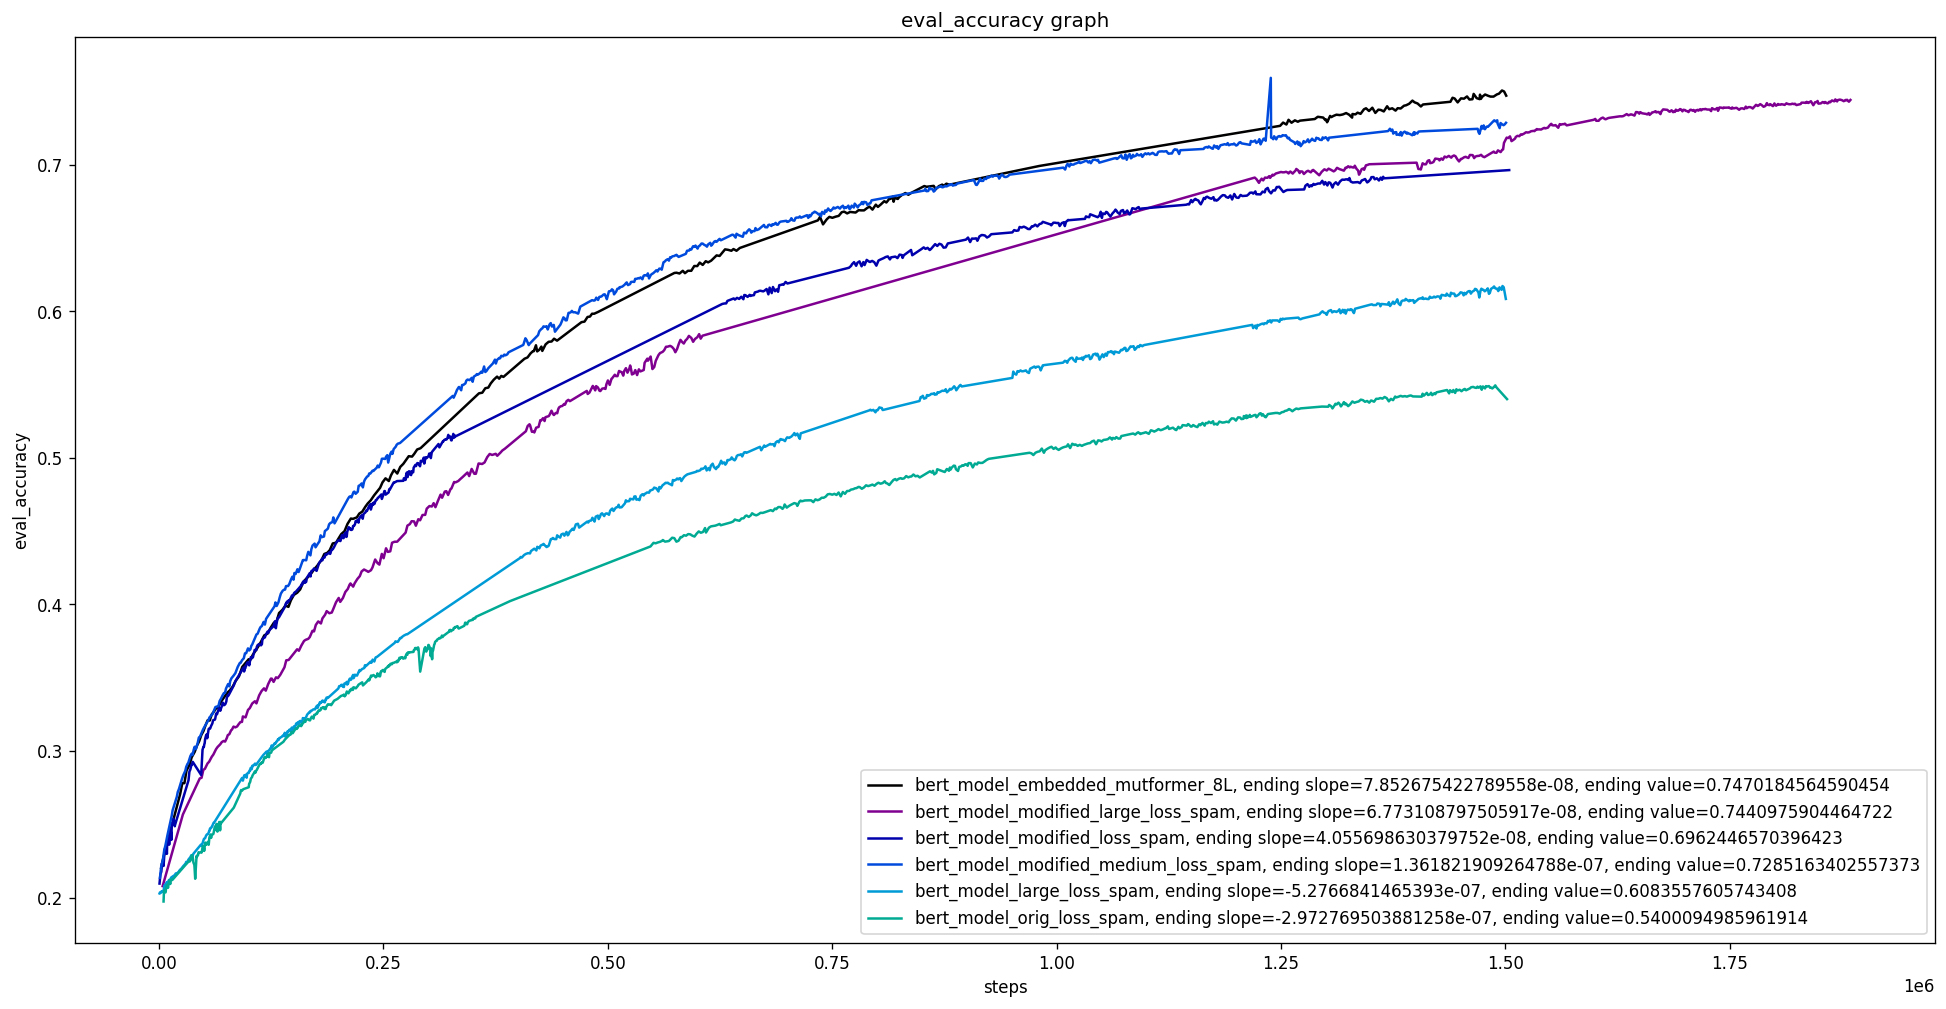

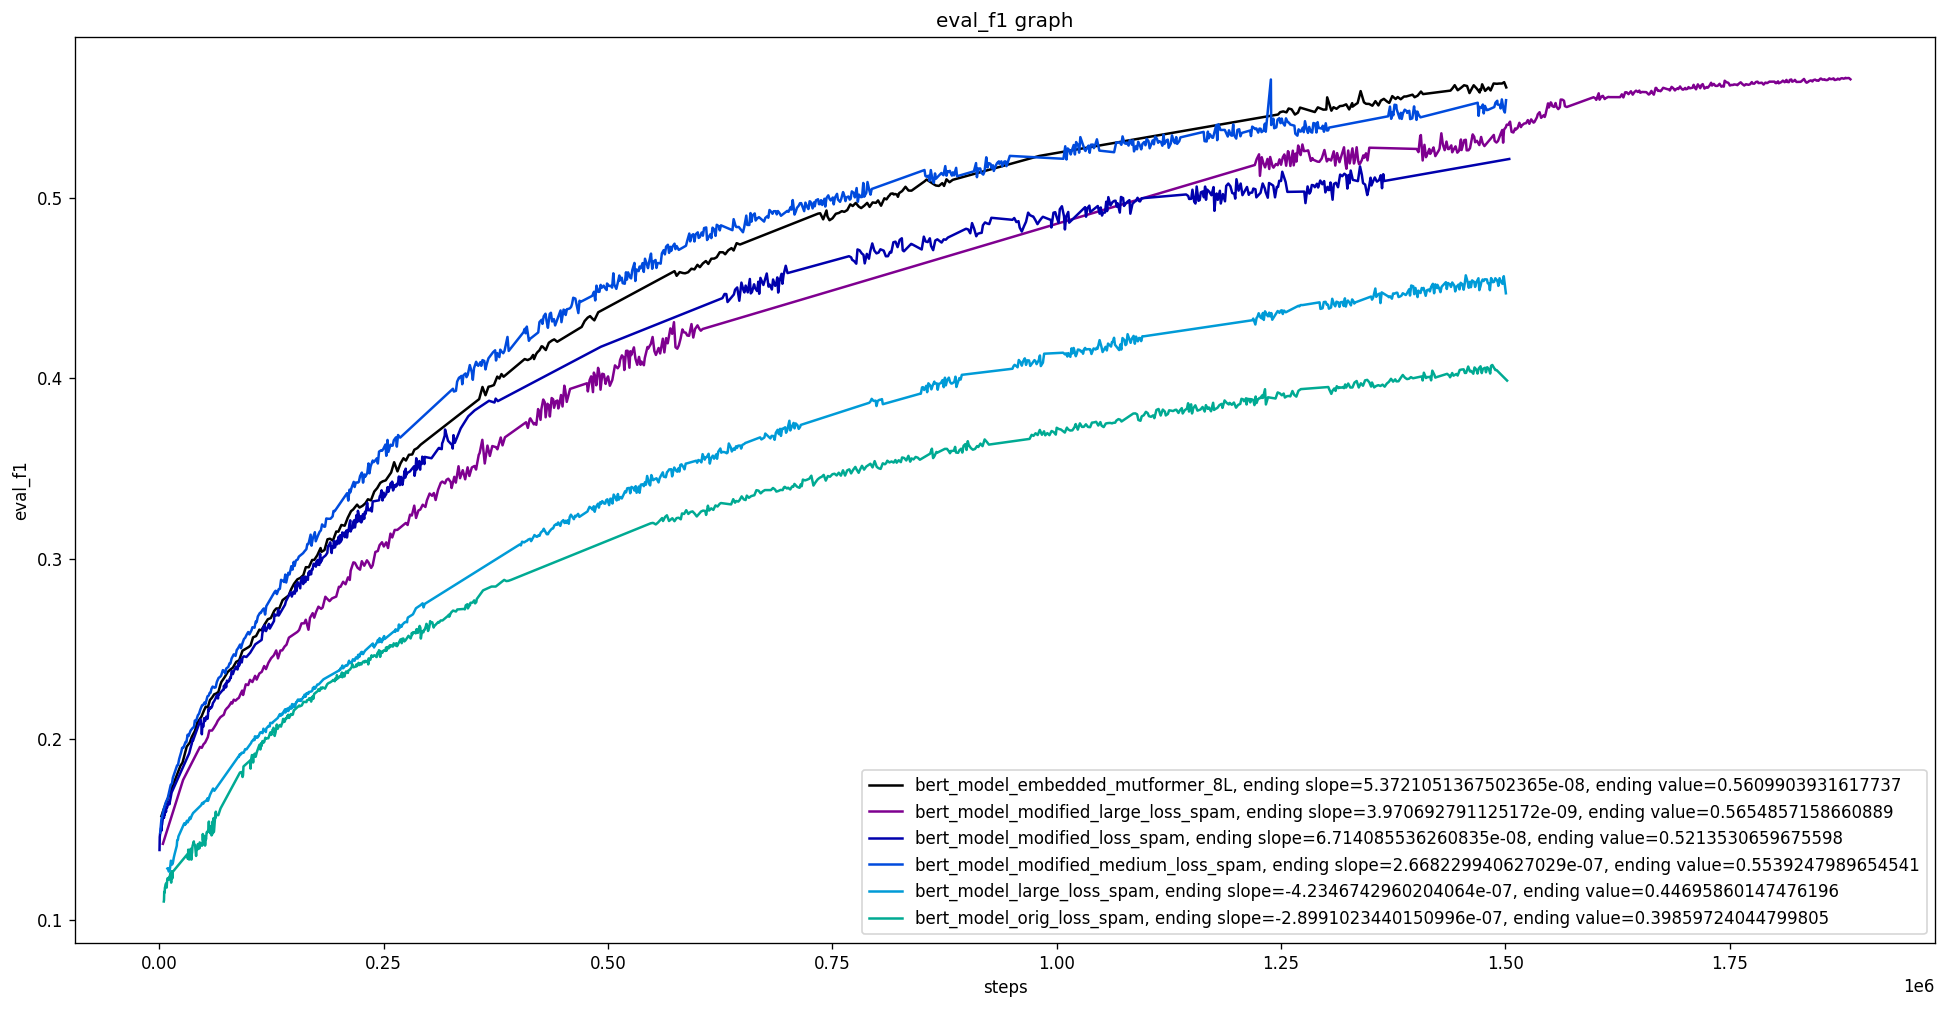

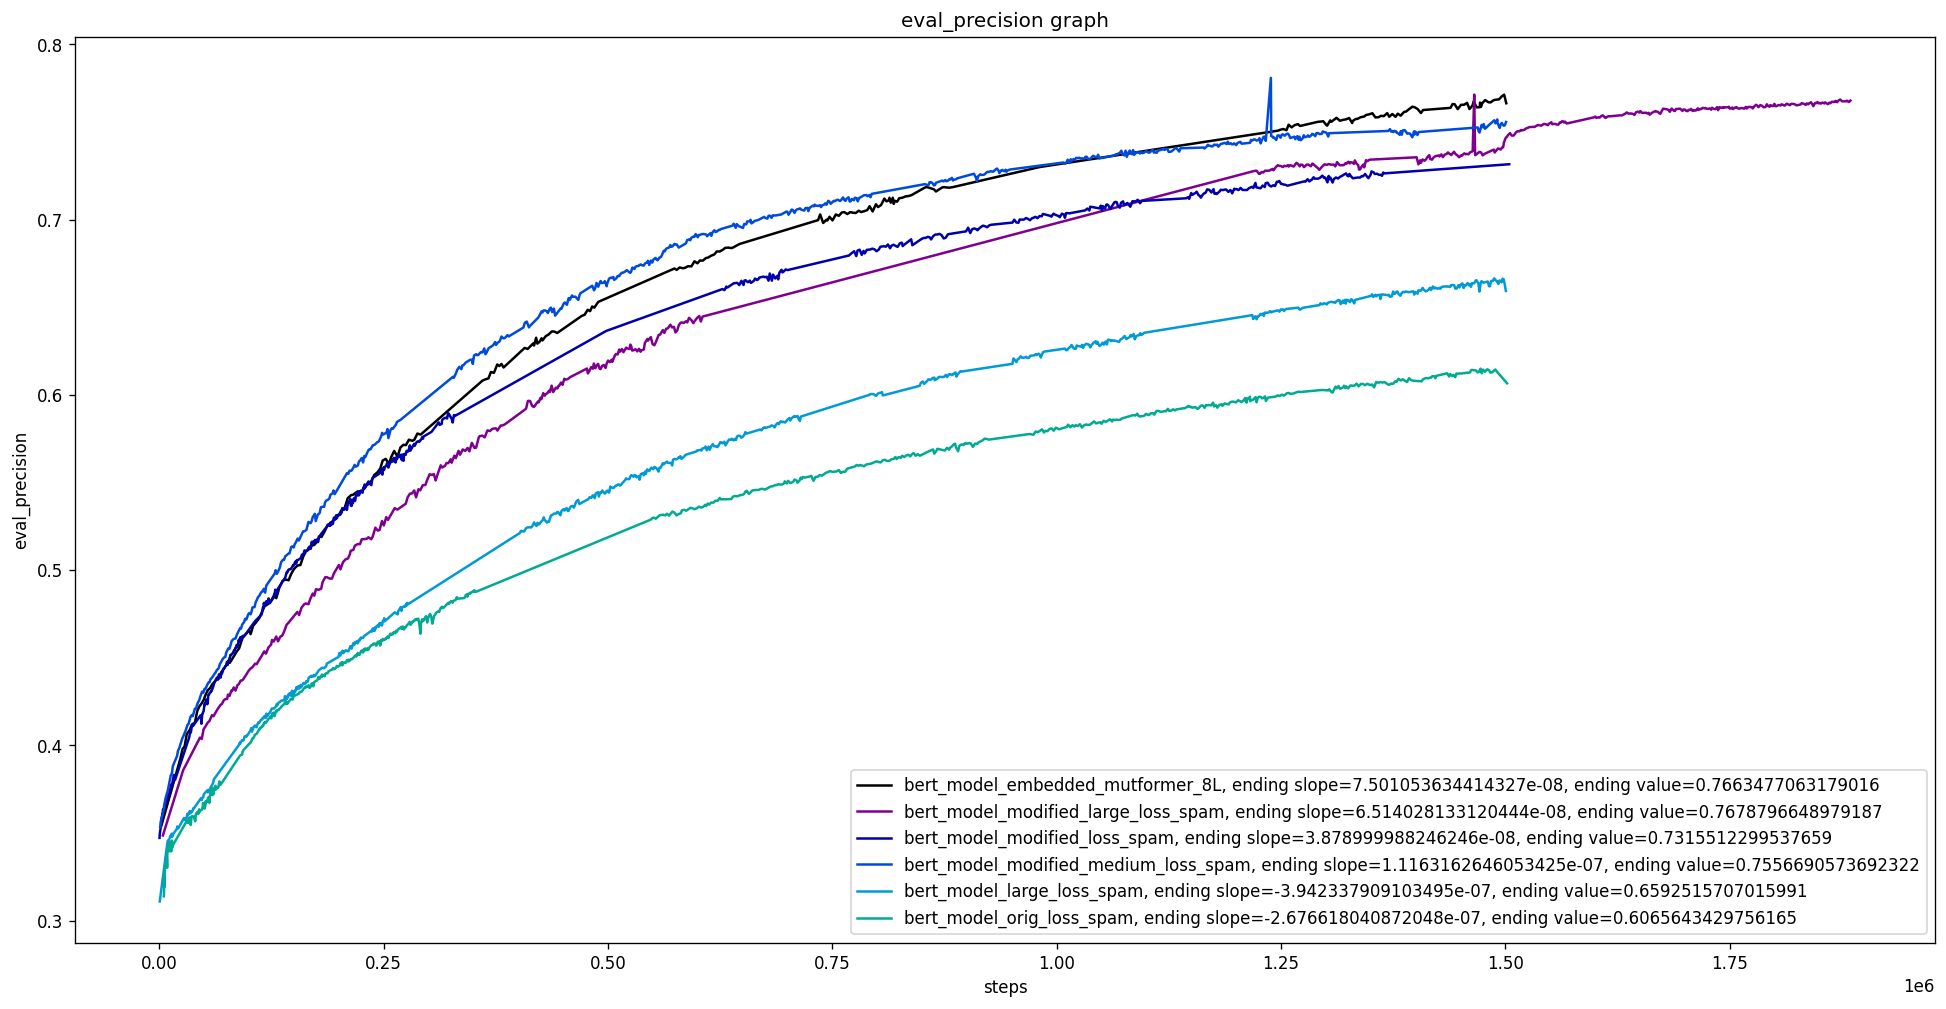

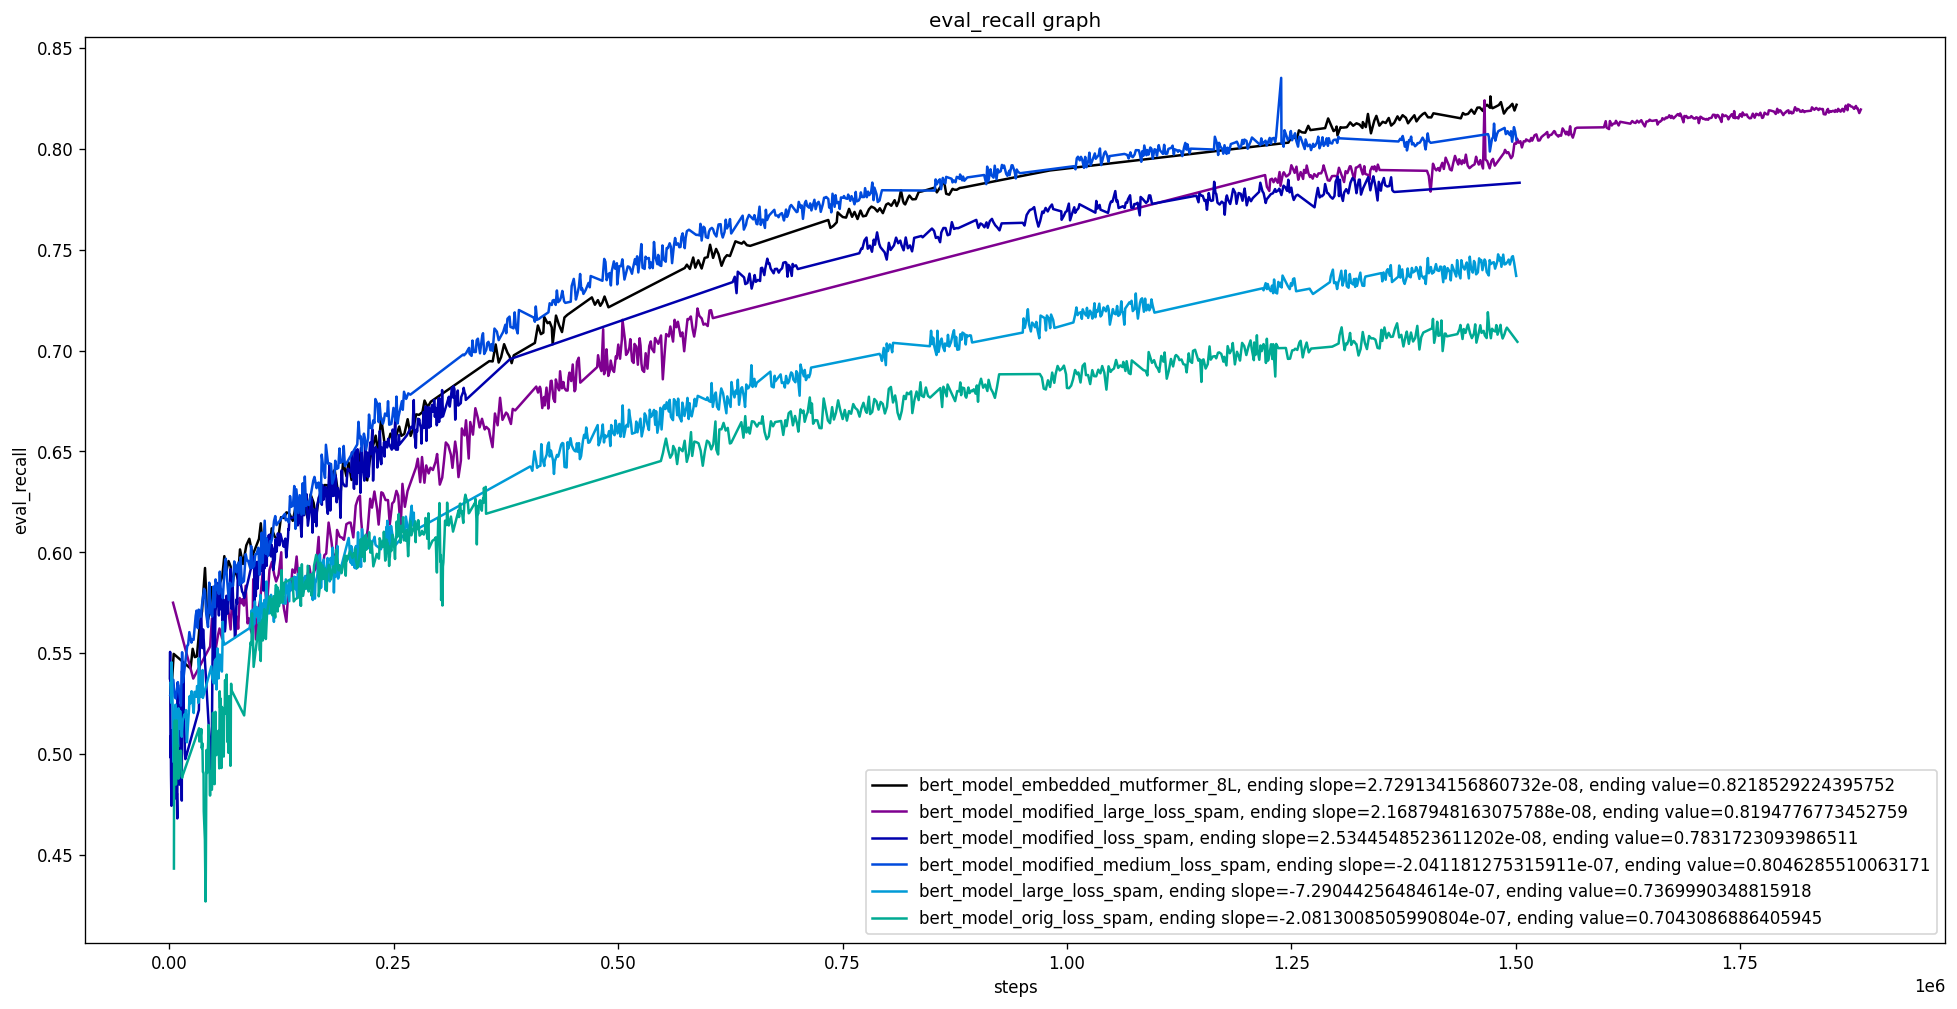

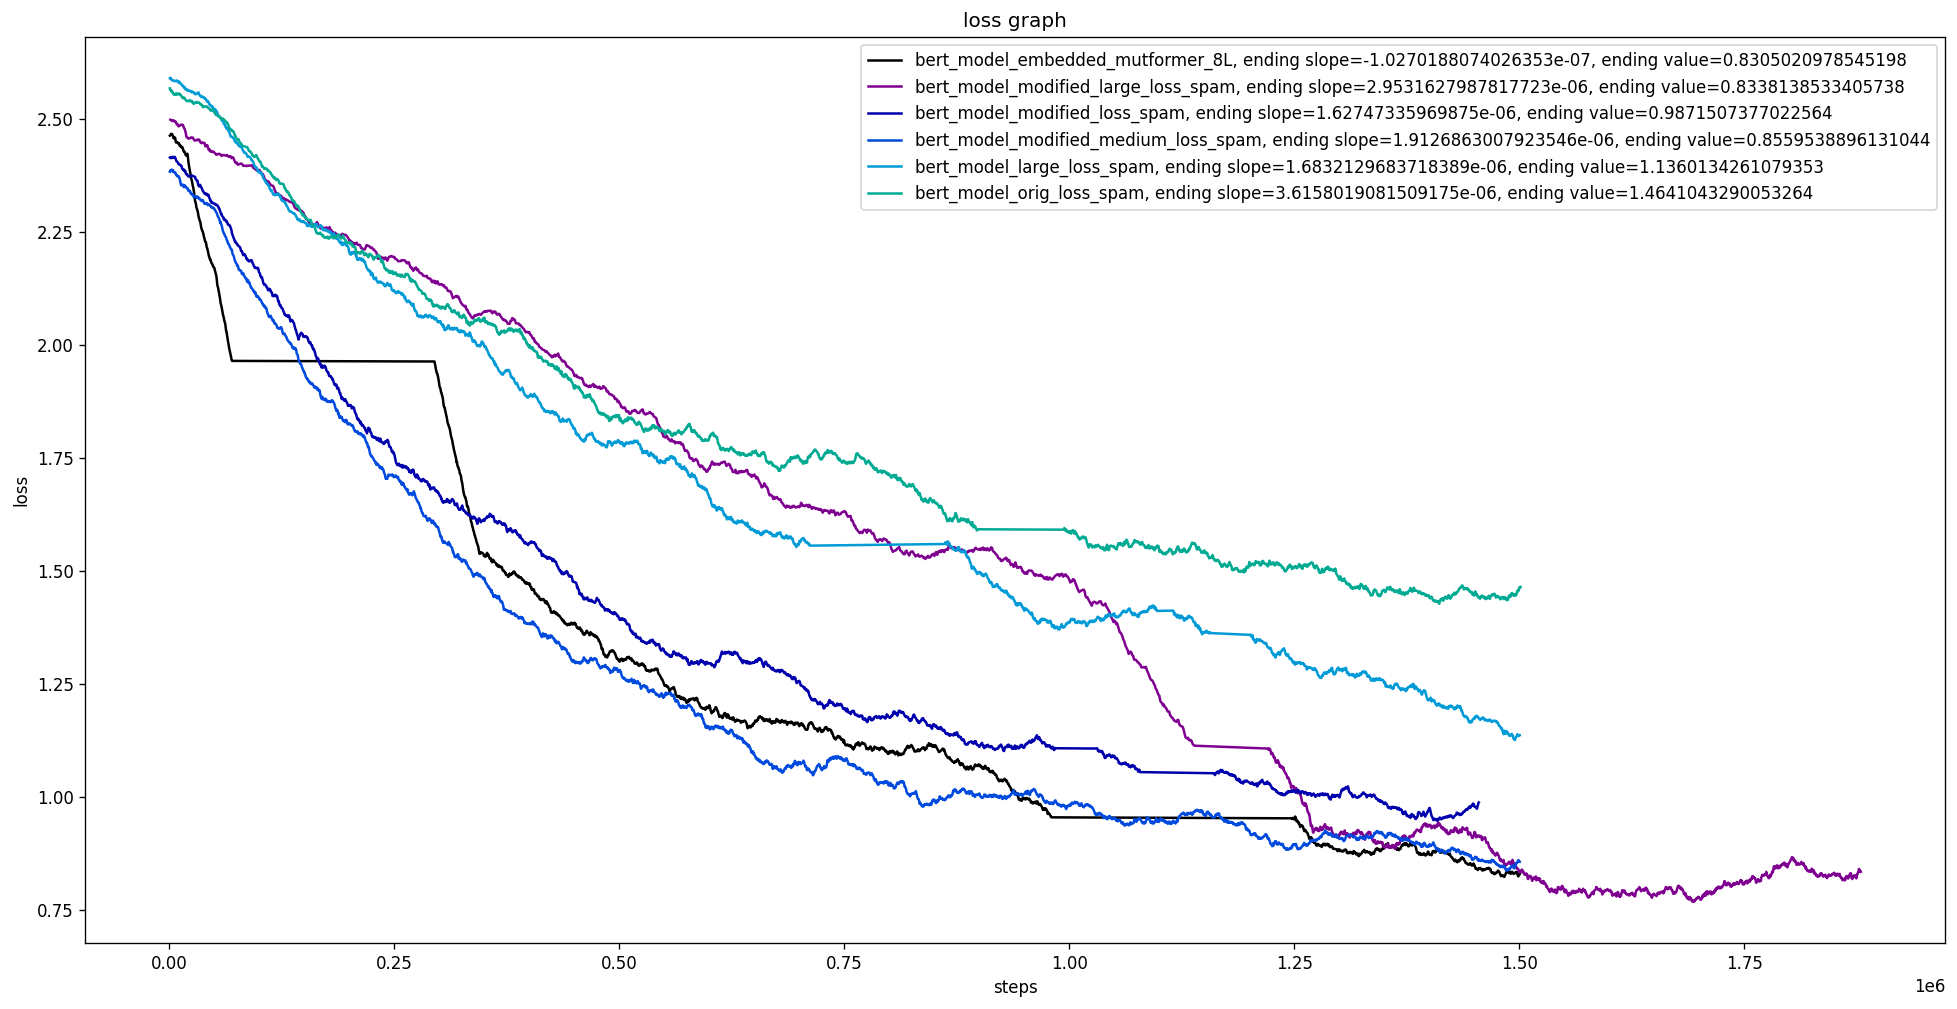

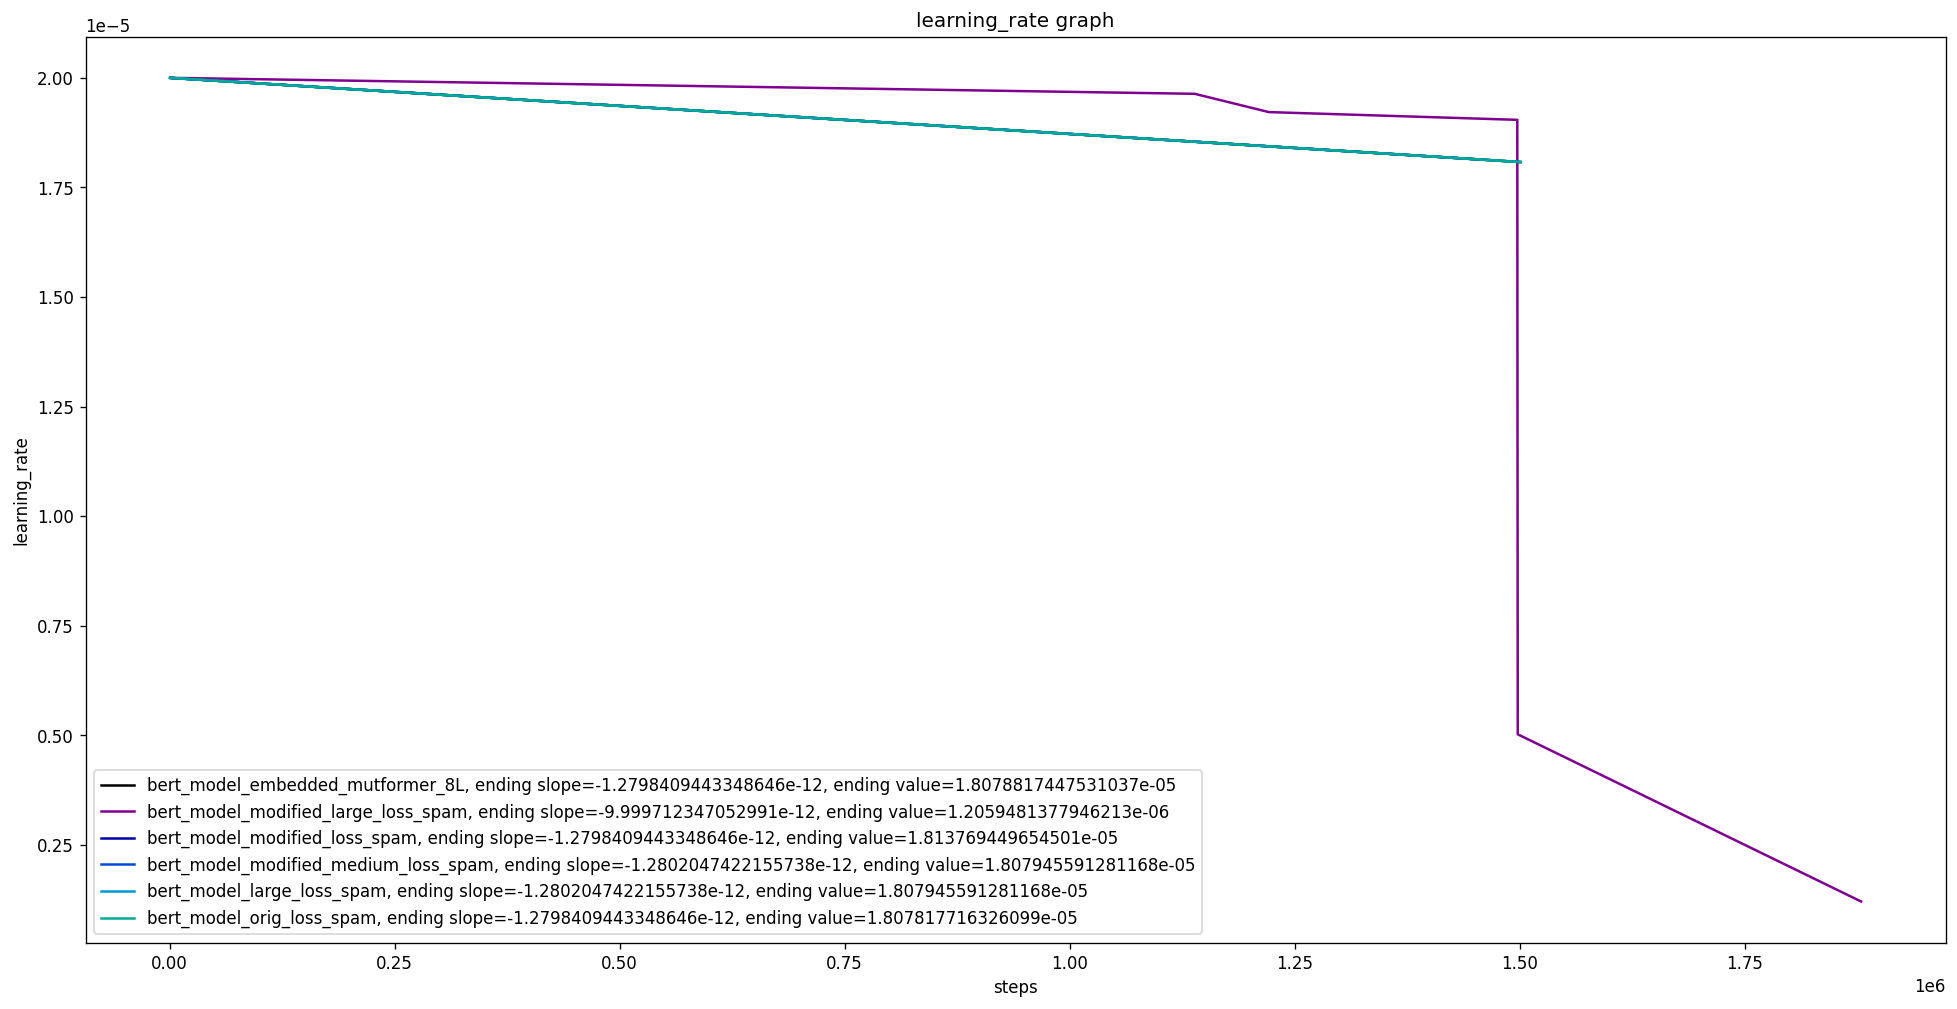

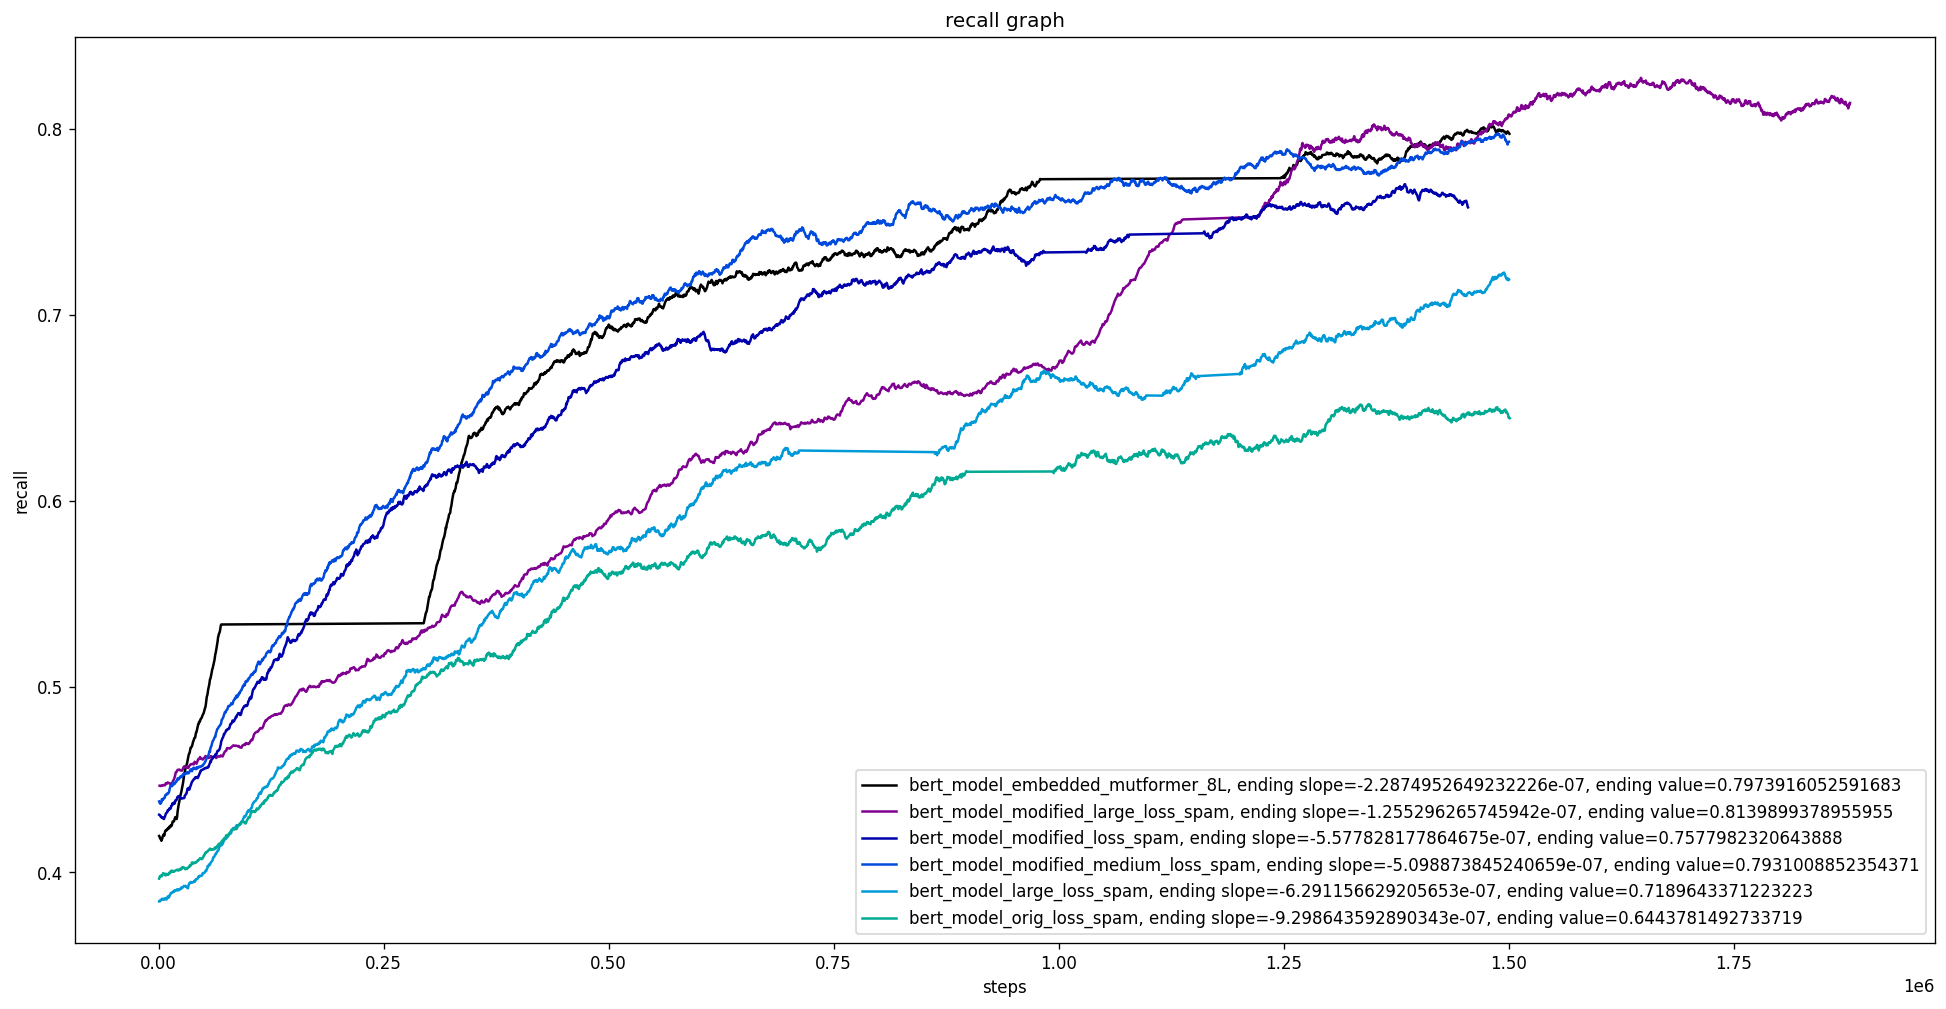

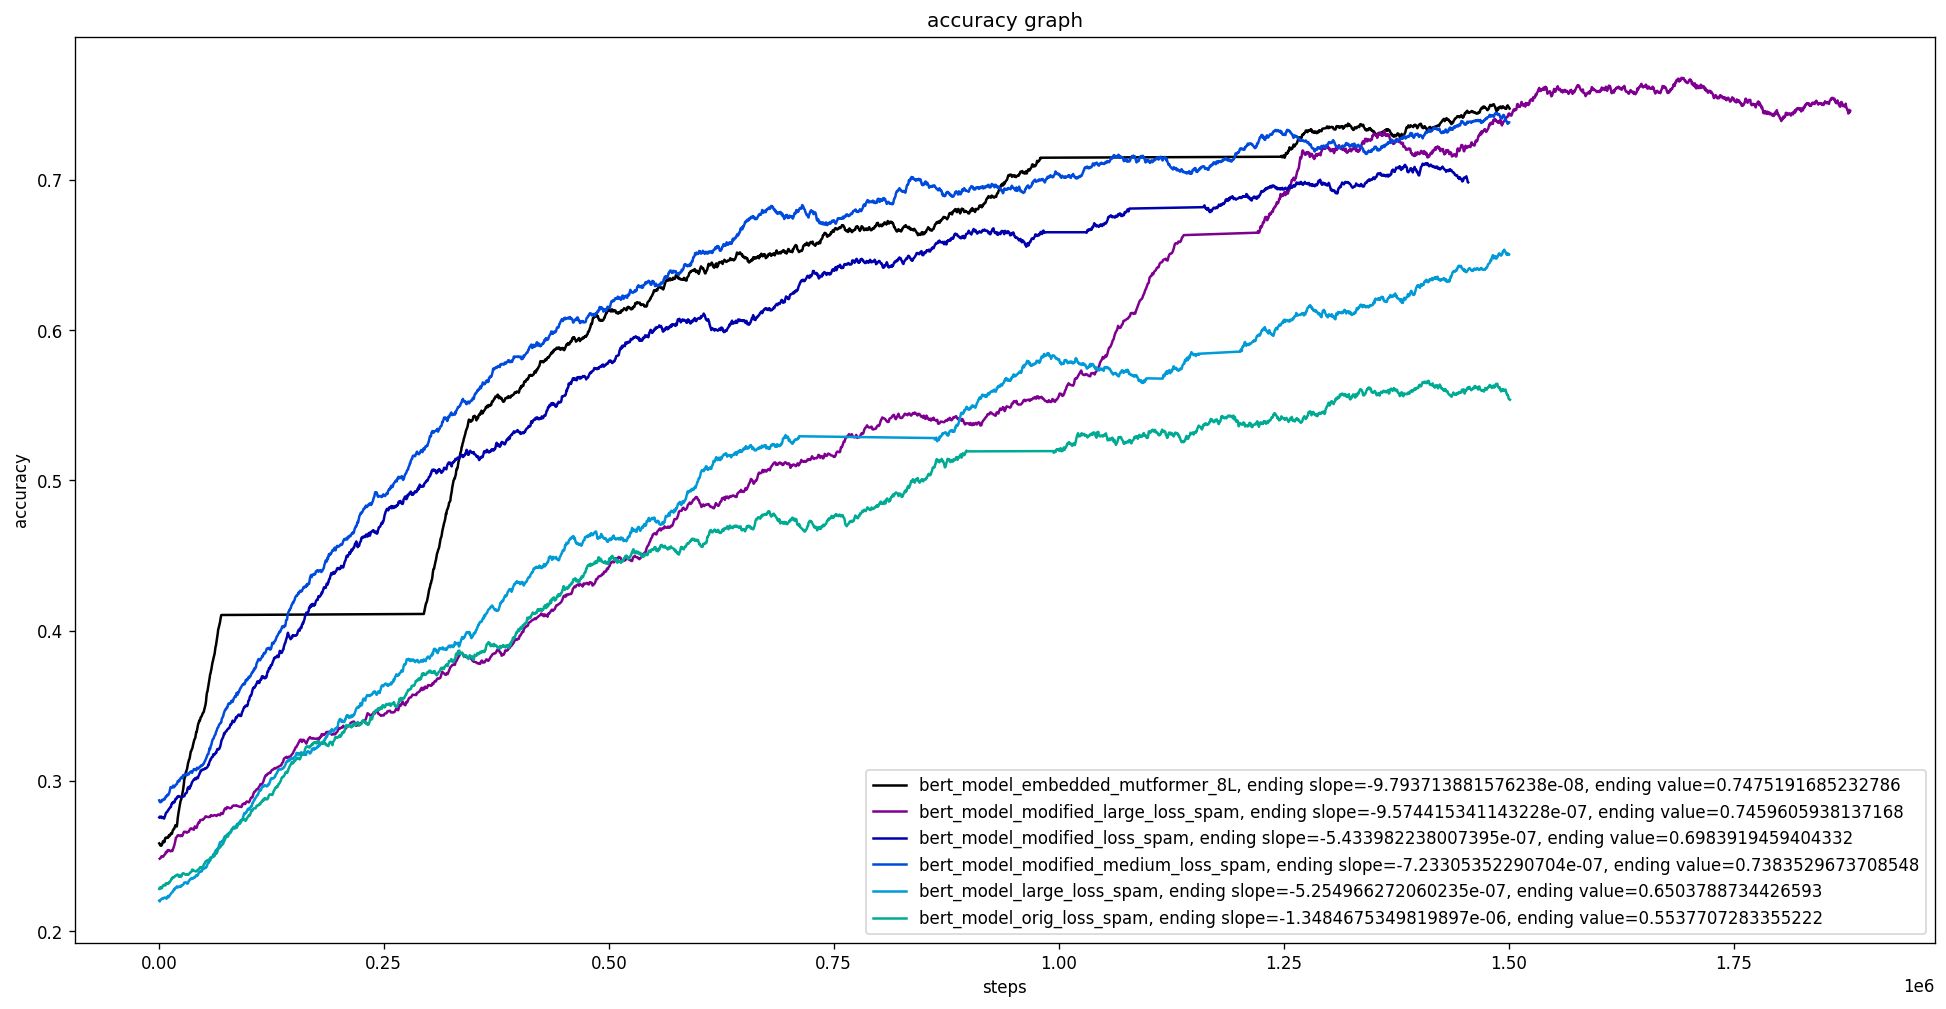

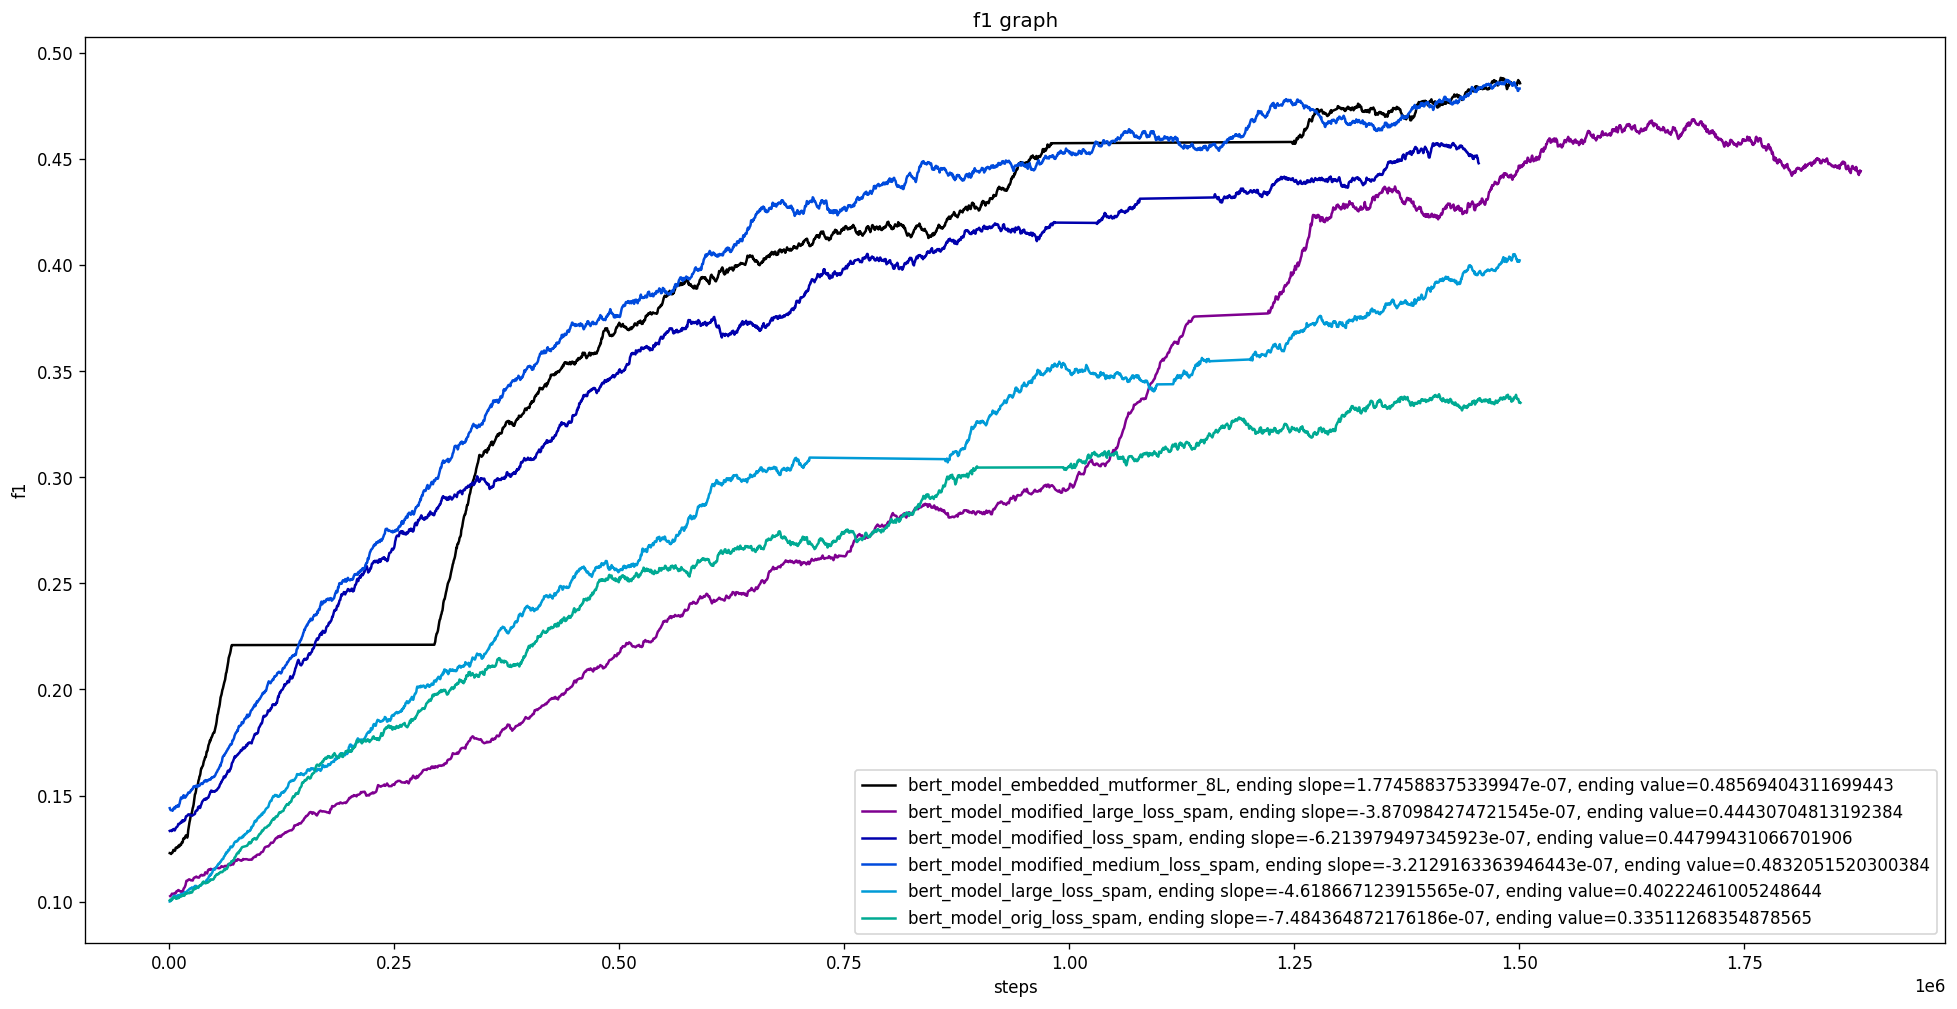

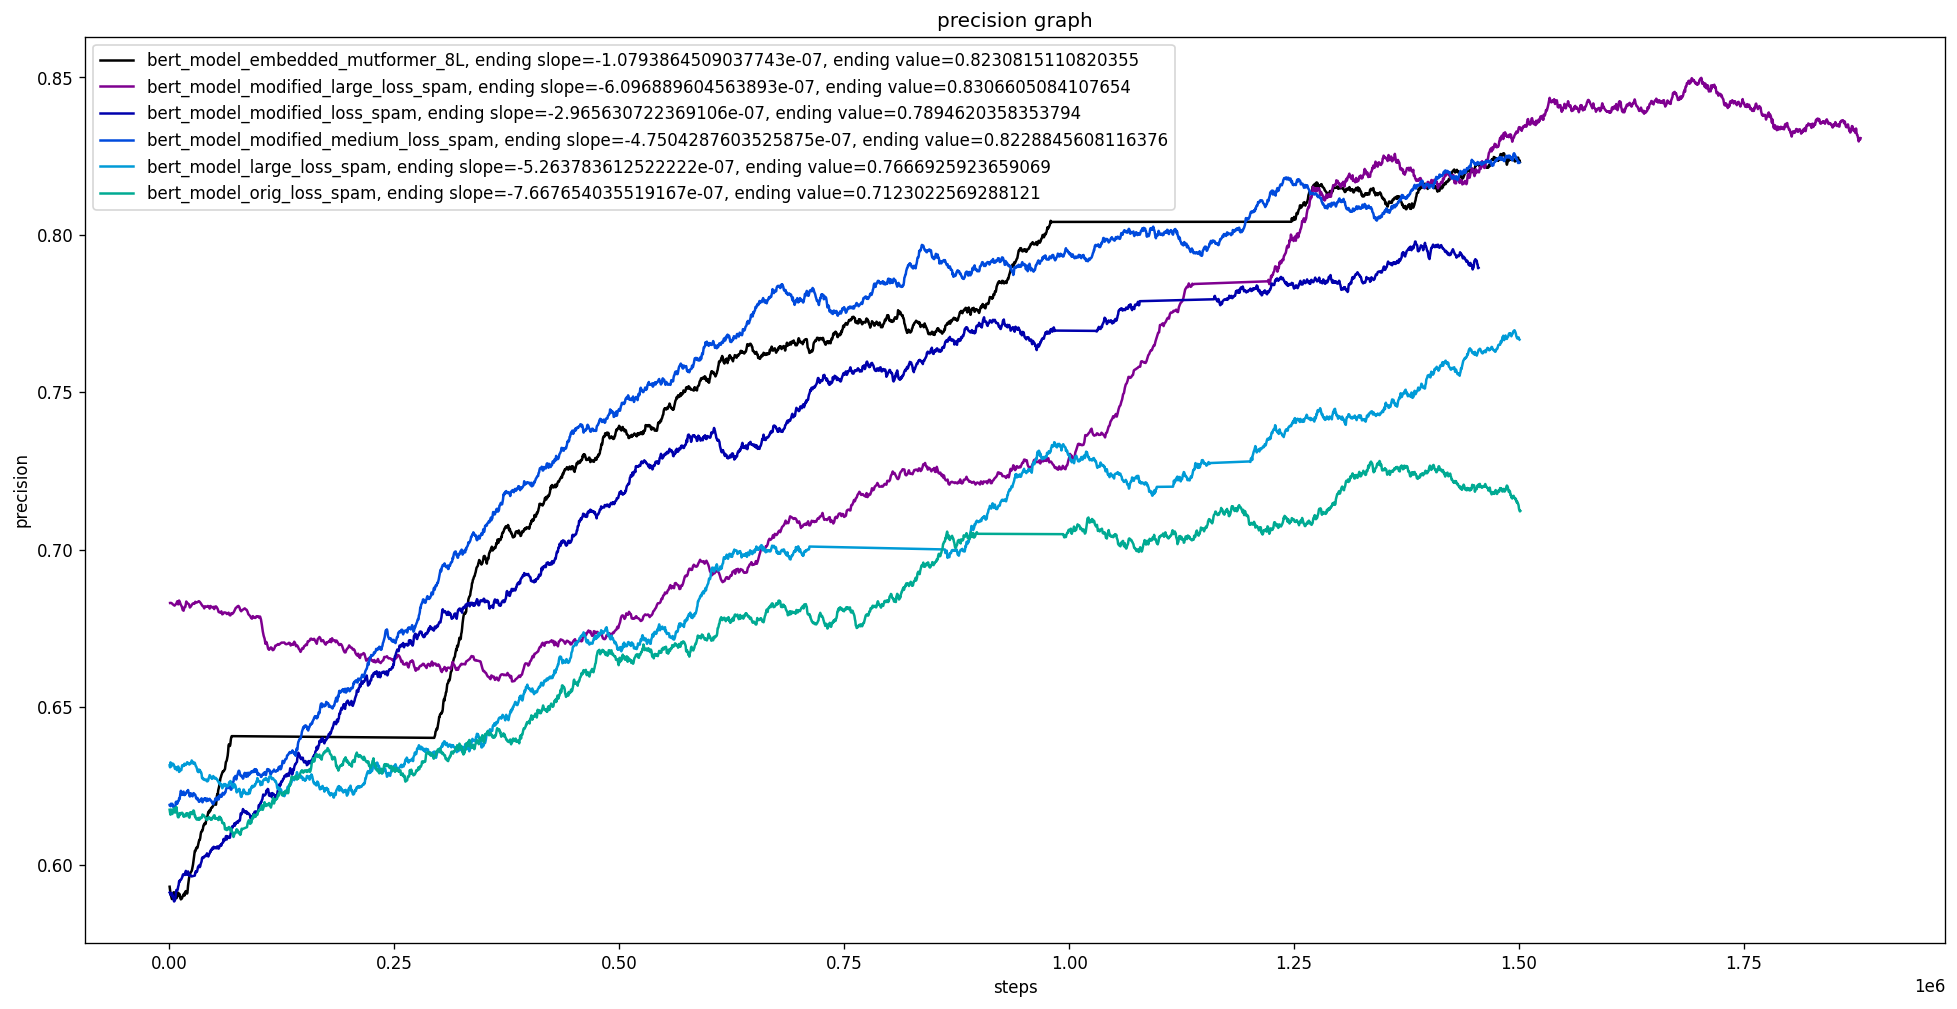

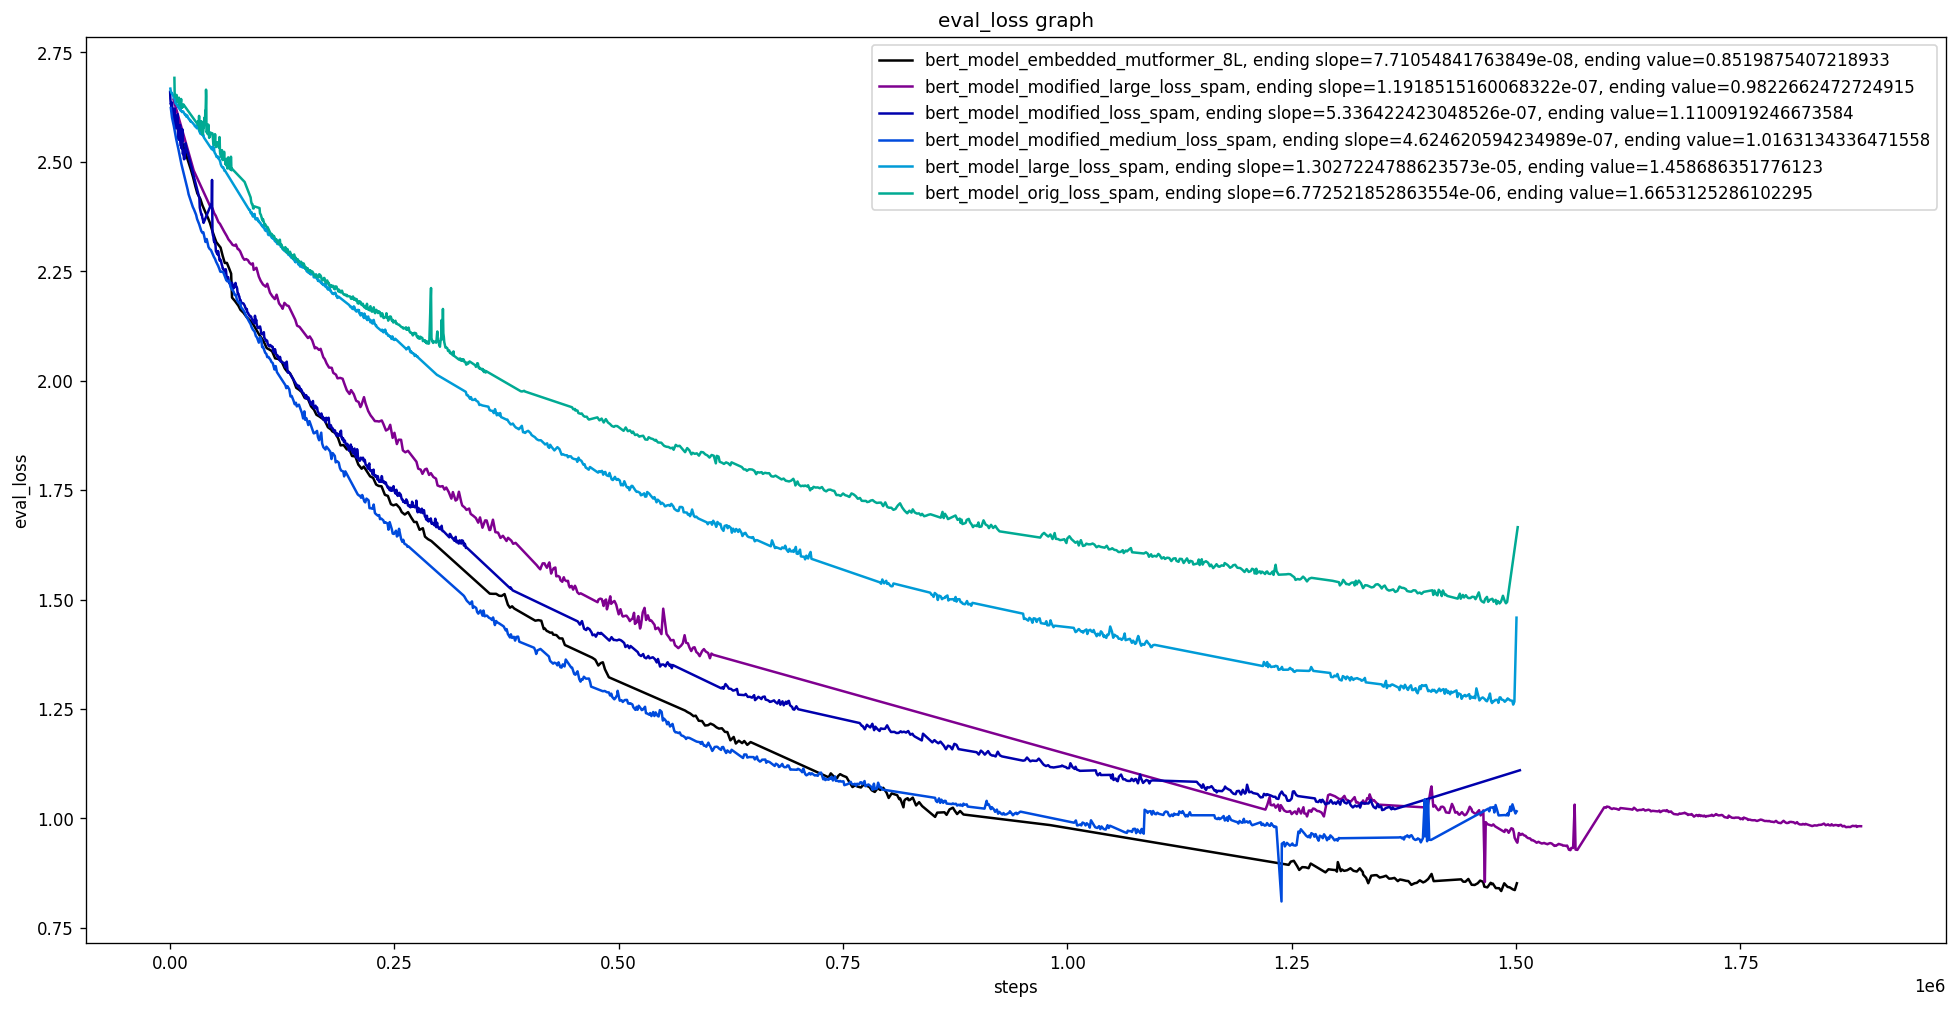

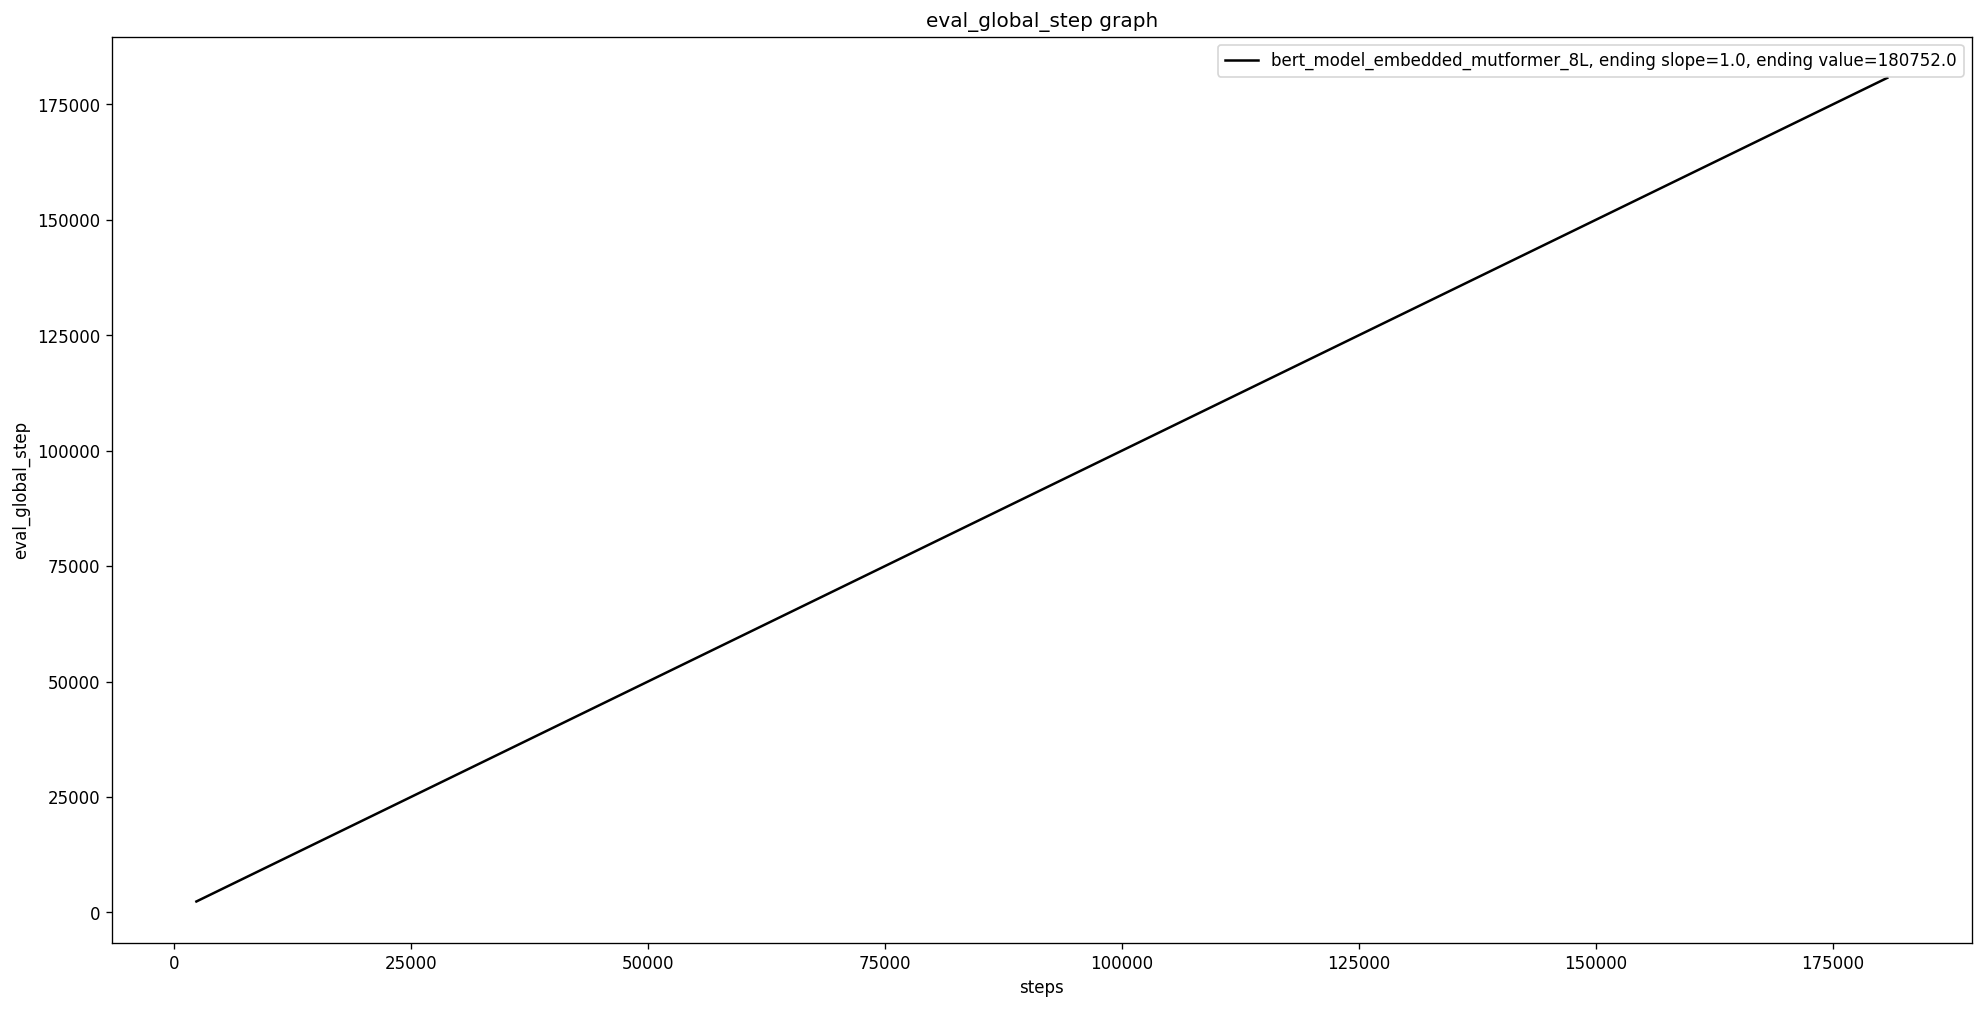

In [7]:
import matplotlib.pyplot as plt
import math

DRIVE_PATH = "/content/drive/MyDrive"

#@markdown range of the local average for viewing train log graphs (not eval logs) (local averaging increases smoothness; to disable local averaging, set it to 0)
avg_range = 100 #@param {type:"integer"}
#@markdown local average range of calculating end slope
slope_avg_range = 10 #@param {type:"integer"}
#@markdown destination path for saving graphs (for no saving set to None)
outfolder = DRIVE_PATH+"/training graphs" #@param
if outfolder and not os.path.exists(outfolder):
  os.makedirs(outfolder)


for metric,runs in graph_data.items():
    if "rando" in metric:
      continue
    fig=plt.figure(figsize=(20,10),dpi=120) ##figsize specifies aspect ratio, dpi specifies resolution
    ax = fig.add_subplot()
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,len(graph_data))]
    ax.set_prop_cycle('color', colors)

    plt.title(metric+" graph")
    plt.xlabel("steps")
    plt.ylabel(metric)
    for run,run_data in runs.items():
        if not run_data: continue
        #if not "distance" in run:
        #  continue

        steps = []
        values = []
        for datapt in run_data:
            
            if not math.isnan(datapt[1]) and not datapt[0] in steps: ##check for nan and repeats
                if datapt[0]==0:
                  continue
                values.append(datapt[1])
                steps.append(datapt[0])
        values = [x for _, x in sorted(zip(steps, values), key=lambda pair: pair[0])]

        if "eval" in metric or "learning_rate" in metric or avg_range == 0: ## evaluation result logs
          avged_values = values
        else:
          avged_values = [sum(values[max(n-avg_range,0):min(n+avg_range,len(values))])/len(values[max(n-avg_range,0):min(n+avg_range,len(values))]) for n,value in enumerate(values)]
        steps = sorted(steps)
        ##calculating slopes between two points
        slopes = [((avged_values[n+slope_avg_range]-v)/(steps[n+slope_avg_range]-steps[n])) for n,v in enumerate(avged_values) if n<len(avged_values)-slope_avg_range]
        if not slopes:
          slopes = [0]

        ax.plot(steps,avged_values,label=f"{run}, ending slope={str(slopes[-1])}, ending value={avged_values[-1]}")
                
    ax.legend()
    if outfolder:
      fig.savefig(outfolder+"/"+metric.replace("/","_")+".png")
    plt.show()


###Tensorboard viewing (If you wish to use tensorboard instead)

In [ ]:
LOGS_DIR = "/content/drive/My Drive" #@param (type:"string")
LOGS_DIR = "\""+LOGS_DIR+"\""
%load_ext tensorboard
%tensorboard --logdir $LOGS_DIR

#Copy a model checkpoint from GCS to drive

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

#@markdown checkpoint folder path:
ckpt_folder = "bert_model_modified" #@param {type:"string"}
#@markdown path to copy checkpoint folder into
destination_folderp = "/content/drive/My Drive/folder-to-copy-to" #@param {type:"string"}

ckpt_folderp = f"gs://{BUCKET_NAME}/{ckpt_folder}"

latest_ckpt = tf.train.latest_checkpoint(ckpt_folderp)
print(latest_ckpt)

cmd = f"gsutil -m cp {latest_ckpt}.data-00000-of-00001 {latest_ckpt}.index {latest_ckpt}.meta {destination_folderp}"
!{cmd}

TensorFlow 1.x selected.
gs://theodore_jiang/bert_model_modified/model.ckpt-1504378


'\n!gsutil -m cp "gs://theodore_jiang/bert_model_modified/model.ckpt-1332386.data-00000-of-00001" \\ ##replace these with whatever files you are trying to copy from GCS\n"gs://theodore_jiang/bert_model_modified/model.ckpt-1332386.index" \\               ##alternatively you can copy the entire command from GCS as well\n"gs://theodore_jiang/bert_model_modified/model.ckpt-1332386.meta" "/content/drive/My Drive/folder-to-copy-to" ##destination folder'

#Check trainable variable values in model checkpoint

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow
import os

#@markdown checkpoint folder path:
ckpt_folder = "bert_model_mrpc_ex_data_all_flbs5_6_2022/fl_0_bs_32" #@param {type:"string"}

ckpt_folderp = f"gs://{BUCKET_NAME}/{ckpt_folder}"
latest_ckpt = tf.train.latest_checkpoint(ckpt_folderp)

reader = pywrap_tensorflow.NewCheckpointReader(latest_ckpt)
var_to_shape_map = reader.get_variable_to_shape_map()

print(f"\n\nReading from checkpoint: {latest_ckpt}\n\n")

with open("ckpt_details.txt","w+") as out:
  for n,key in enumerate(var_to_shape_map):
    if "combine" in key:
      print(f"tensor number {n}: tensor_name: ", key)
      out.write(f"\n{key}:\n")
      out.write("\n".join([str(row) for row in reader.get_tensor(key)]))
  



Reading from checkpoint: gs://theodore_jiang/bert_model_mrpc_ex_data_all_flbs5_6_2022/fl_0_bs_32/model.ckpt-12000


tensor number 10: tensor_name:  extra_data_layers/combine_dense/kernel/adam_v
tensor number 11: tensor_name:  extra_data_layers/combine_dense/kernel/adam_m
tensor number 12: tensor_name:  extra_data_layers/combine_dense/kernel
tensor number 13: tensor_name:  extra_data_layers/combine_dense/bias
tensor number 196: tensor_name:  extra_data_layers/combine_dense/bias/adam_v
tensor number 250: tensor_name:  extra_data_layers/combine_dense/bias/adam_m
